# Simple predictive cricket model using ball by ball test match data

I’ve built a simple cricket model for ratings batsmen and bowlers based on ball by ball test match data from cricsheet stretching back over the last 12 years. The notebook demos the model and drills into the ratings for the English players in more detail comparing them to simple batting and bowling averages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
from footballradar.misc.cricket_model import CricketModel
from footballradar.misc import cricket_data_fetcher
import arviz
%load_ext autoreload
%autoreload 2

# Data fetching and cleaning

I extract test match data (ball by ball data and metadata) from cricsheet and have written a few functions to parse the ball by ball data from the yaml files

In [2]:
zipped_files, list_of_yamls = cricket_data_fetcher.fetch_cricsheet_data()

It takes c15secs to parse all the data for each game from the yaml. Since there are 550+ games, I've pickled the ball by ball data and metadata to save anyone a wait when re-running the notebook

In [3]:
try:
    df_metadata = pd.read_pickle('df_metadata.pkl')
    df_ball_by_ball = pd.read_pickle('df_ball_by_ball.pkl')
except:
    df_ball_by_ball, df_metadata = cricket_data_fetcher.extract_data_from_yamls(zipped_files, list_of_yamls)

# STAN Model 

The model is set up as a binary logistic regression where a wicket represents a 1 and all other balls represent a 0 with weights added to take into account runs and dot balls. The model is a rudimentary one as I don’t include additional features (venue, pitch state, current scoreline, new ball flag, etc) which would likely improve predictions and model fit further. 

In [4]:
cricket_code = """
data {
  int<lower=1> N; // number of balls
  int<lower=1> B; // number of batsman
  int<lower=1> K; // number of bowlers
  int<lower=1,upper=B> batsman[N];
  int<lower=1,upper=K> bowler[N];
  int<lower=0,upper=1> result[N];
  vector<lower=0>[N] weight;
  vector[B] starting_guess_bat;
  vector[K] starting_guess_bowl;
  real<lower=0> sigma_bat;
  real<lower=0> sigma_bowl;
}
parameters {
  // parameters
  vector[B] bat_ability;
  vector[K] bowl_ability;
  real base_rate;
}
model {
  // priors
  bat_ability ~ normal(starting_guess_bat, sigma_bat);
  bowl_ability ~ normal(starting_guess_bowl, sigma_bowl);
  // likelihood
  for (n in 1:N){
    target += weight[n] * bernoulli_logit_lpmf(result[n] | base_rate
                                                           + bat_ability[batsman[n]] - bowl_ability[bowler[n]]);
  }
}
"""

For each batter, the model takes into account the bowler faced and vice-versa. The model ratings should, therefore, be a cleaner reflection of player ability than just using simple batting and bowling averages. For example, if a player plays a relatively high number of games against strong/weak test sides, they'll receive more/less credit in the model relative to looking at simple averages. The model also allows a comparison of players across different eras taking into the quality of the players they faced in that era. 

# Fit Model

I fit the model below using the pickled data and using the STAN code shown above. The more negative the rating score, the stronger the batsman or bowler (although these signs can easily be flipped)

In [5]:
df = CricketModel.fit(cricket_code=cricket_code,
                      df_ball_by_ball=df_ball_by_ball, 
                      df_metadata=df_metadata, 
                      fit_with_mcmc=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5c2b385373b322fb4a750dac0dfb156 NOW.


**Top 15 test match batsmen over the last 12 years playing 20 or more games**

Unsurprisingly, Steve Smith comes out as the best batsman with Chanderpaul and de Villiers not too far behind. Interestingly, the relative difference between Smith's rating and the other top batsmen is smaller than the relative difference in batting averages. This likely reflects the fact that Smith doesn't have to face a very strong Australian attack and has, as a result, scored his runs against slightly weaker bowlers. If I reduce the games played requirement to >10, Labuschagne and Voges also enter the top 10. Cook and Root both respectably make the top 15. 

In [23]:
df.batsmen.query('games>=20').reset_index().head(15)

,batsman_id,batsman,team,games,ba,sr,rating,rating_std
0,229,SPD Smith,Australia,71,62.72,113.05,-1.097589,None
1,70,S Chanderpaul,West Indies,56,56.77,130.99,-1.042460,None
2,56,AB de Villiers,South Africa,80,56.71,103.23,-1.015009,None
3,268,CA Pujara,India,75,49.91,108.26,-0.995741,None
4,286,V Kohli,India,84,52.85,91.91,-0.964868,None
5,105,TT Samaraweera,Sri Lanka,39,56.93,112.02,-0.959909,None
6,103,KC Sangakkara,Sri Lanka,61,56.89,108.37,-0.941834,None
7,270,KS Williamson,New Zealand,80,50.59,98.12,-0.936042,None
8,185,Younis Khan,Pakistan,58,51.78,102.67,-0.925593,None
9,53,HM Amla,South Africa,105,48.76,96.40,-0.917293,None


**Top 15 test match bowlers over the last 12 years**

Auastralian bowlers dominate the top 15 with Cummins, Starc and Hazelwood all present. It's no wonder India had such a hard time of it in the recent test!

In [19]:
df.bowlers.query('games>=20').reset_index().head(15)

,bowler_id,bowler,team,games,ba,sr,rating,rating_std
0,355,K Rabada,South Africa,42,21.47,39.74,-0.666023,None
1,219,PJ Cummins,Australia,30,20.97,46.93,-0.663616,None
2,216,VD Philander,South Africa,64,21.65,50.86,-0.611440,None
3,170,RJ Harris,Australia,27,23.05,50.59,-0.611244,None
4,31,DW Steyn,South Africa,77,21.76,42.54,-0.603394,None
5,226,JL Pattinson,Australia,21,24.95,49.99,-0.526555,None
6,18,JM Anderson,England,135,24.27,53.66,-0.526429,None
7,33,M Morkel,South Africa,85,25.74,53.11,-0.523509,None
8,227,MA Starc,Australia,57,26.00,47.55,-0.519763,None
9,146,KAJ Roach,West Indies,57,26.60,54.39,-0.517010,None


**Top 10 English test match batsmen over the last 12 years**

The top English batsmen is not too surprising. Sibley, Pope and Denly rank relatively highly depite their fairly modest batting averages. This likely reflects the fact they've played a relatively large number of tests against strong oppostiion (e.g. South Africa and Australia) with a current crop of very strong bowlers

In [8]:
df.batsmen.query('games>=10').loc[lambda df: df['team'] == 'England'].reset_index().head(10)

,batsman_id,batsman,team,games,ba,sr,rating,rating_std
0,39,AN Cook,England,137,45.22,96.18,-0.887888,None
1,662,DP Sibley,England,12,38.11,104.17,-0.882499,None
2,352,JE Root,England,97,47.41,87.22,-0.875596,None
3,42,IR Bell,England,85,41.78,86.03,-0.760225,None
4,38,AJ Strauss,England,57,41.01,86.14,-0.740986,None
5,41,KP Pietersen,England,70,45.64,76.18,-0.739035,None
6,571,OJ Pope,England,13,37.94,72.12,-0.716505,None
7,378,BA Stokes,England,67,37.53,64.32,-0.702203,None
8,626,JL Denly,England,15,30.63,77.56,-0.690891,None
9,154,IJL Trott,England,52,43.09,91.69,-0.649667,None


**Top 10 English test match bowlers over the last 12 years**

Andersen clearly leads the way in terms of the bowlers with Swann far and away the best spinner

In [9]:
df.bowlers.query('games>=10').loc[lambda df: df['team'] == 'England'].reset_index().head(10)

,bowler_id,bowler,team,games,ba,sr,rating,rating_std
0,18,JM Anderson,England,135,24.27,53.66,-0.526429,None
1,342,MA Wood,England,16,30.04,56.32,-0.440344,None
2,269,CR Woakes,England,38,27.55,55.37,-0.425672,None
3,19,SCJ Broad,England,141,26.64,55.34,-0.394941,None
4,477,JC Archer,England,11,29.18,62.18,-0.387794,None
5,17,RJ Sidebottom,England,11,24.36,53.58,-0.350475,None
6,99,GP Swann,England,60,28.93,58.14,-0.349749,None
7,288,BA Stokes,England,64,30.13,56.66,-0.338902,None
8,176,ST Finn,England,36,29.44,50.83,-0.305577,None
9,435,MJ Leach,England,10,29.00,60.97,-0.305468,None


# Compare ratings from the model with bowling and batting averages

As mentioned above, the ratings from the model take into account the quality of the opponent faced. They batsman and bwoler ratings should be strongly correlated with batting and bowling averages but there will be differences too, largely driven by the relative strength of the opposition each player has faced

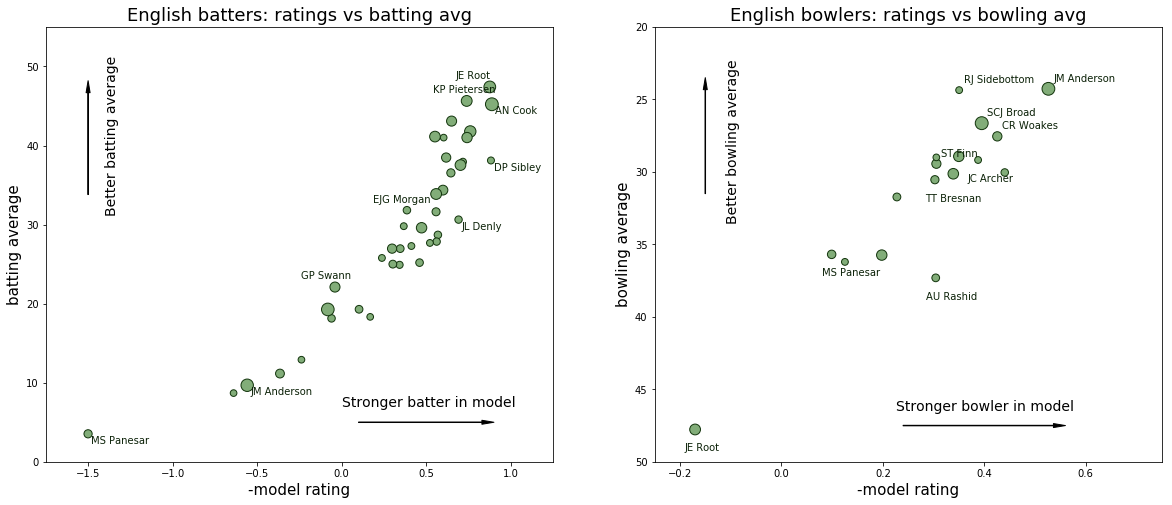

In [74]:
english_batters = df.batsmen.query('games>=10').loc[lambda df: df['team'] == 'England'].reset_index()
english_bowlers = df.bowlers.query('games>=10').loc[lambda df: df['team'] == 'England'].reset_index()

fig, ax = plt.subplots(1, 2, figsize=[20, 8])
axes = ax.ravel()

axes[0].scatter(-english_batters['rating'], english_batters['ba'], s=np.sqrt(english_batters['games']) * 14, 
                color='#82ad79', edgecolor='#14360e')

axes[1].scatter(-english_bowlers['rating'], english_bowlers['ba'], s=np.sqrt(english_bowlers['games']) * 14, 
                color='#82ad79', edgecolor='#14360e')

# annotate the batsman plot with selected batters
for _, row in english_batters.iterrows():
    if row['batsman'] in ['AN Cook', 'DP Sibley', 'JL Denly', 'MS Panesar', 'JM Anderson']:
        axes[0].annotate(row['batsman'], xy=(-row['rating'] + 0.02, row['ba'] - 1.25), color='#0b2107')
    if row['batsman'] in ['EJG Morgan', 'JE Root', 'KP Pietersen', 'GP Swann']:
        axes[0].annotate(row['batsman'], xy=(-row['rating'] - 0.2, row['ba'] + 1), color='#0b2107')

# annotate the bowlers plot with selected bowlers
for _, row in english_bowlers.iterrows():
    if row['bowler'] in ['JM Anderson', 'CR Woakes', 'SCJ Broad', 'ST Finn', 'RJ Sidebottom']:
        axes[1].annotate(row['bowler'], xy=(-row['rating'] + 0.01, row['ba'] - 0.5), color='#0b2107')
    if row['bowler'] in ['MS Panesar', 'TT Bresnan', 'JC Archer', 'JE Root', 'AU Rashid']:
        axes[1].annotate(row['bowler'], xy=(-row['rating'] - 0.02, row['ba'] + 1.5), color='#0b2107')

# chart titles and axes
axes[0].set_title('English batters: ratings vs batting avg', fontsize=18)
axes[0].set_xlabel('-model rating', fontsize=15)        
axes[0].set_xlim([-1.75, 1.25])
axes[0].set_ylabel('batting average', fontsize=15)
axes[0].set_ylim([0, 55])
axes[1].set_title('English bowlers: ratings vs bowling avg', fontsize=18)
axes[1].set_xlabel('-model rating', fontsize=15)        
axes[1].set_xlim([-0.25, 0.75])
axes[1].set_ylabel('bowling average', fontsize=15)
axes[1].set_ylim([50, 20])
    
# add arrows to chart
arrow_properties = dict(facecolor="black", width=0.5, headwidth=4, shrink=0.1)
axes[0].annotate('', xytext=(0, 5), xy=(1, 5), arrowprops=arrow_properties)
axes[0].annotate('Stronger batter in model', xytext=(0, 7), xy=(0, 7), fontsize=14, rotation=0)
axes[0].annotate('', xytext=(-1.5, 32), xy=(-1.5, 50), arrowprops=arrow_properties)
axes[0].annotate('Better batting average', xytext=(-1.4, 50), xy=(-1.4, 50), fontsize=14, rotation=90)
axes[1].annotate('', xytext=(0.2, 47.5), xy=(0.6, 47.5), arrowprops=arrow_properties)
axes[1].annotate('Stronger bowler in model', xytext=(0.225, 46.5), xy=(0.225, 46.5), fontsize=14, rotation=0)
axes[1].annotate('', xytext=(-0.15, 32.5), xy=(-0.15, 22.5), arrowprops=arrow_properties)
axes[1].annotate('Better bowling average', xytext=(-0.11, 23), xy=(-0.11, 23), fontsize=14, rotation=90)
    
plt.show()

The visualisations illustrate the fairly strong correlation between model ratings and batting and bowling averages. They also show the outlier players such as Sibley and Denly who are relatively highly rated in the model relative to their batting averages. This is likely a combination of them playing fewer games (i.e. their ratings are noisier) and generally coming up against relatively stronger bowling opposition. 